# Day-75: Text Generation using RNN

In the last few days, we explored RNNs, LSTMs, GRUs, and Bidirectional Networks, learning how these models understand sequential data like text or time series.

Today, we’ll take it one step further — and build something creative:
A Text Generator using RNNs!

We’ll train an RNN on a children’s stories corpus, and then make it generate new story text word-by-word — just like how ChatGPT or any AI writer starts from a word and keeps predicting the next one.

## Topics Covered

- About the Dataset

- Revisiting NLP Concepts We’ll Use

- Preparing Data for RNN Text Generation

- Building the RNN Model

- Generating Text Word-by-Word

- Evaluation & Experimentation

## The Dataset: Children Stories Text Corpus (Kaggle)

Guys, for any project, the first step is always the data! Our dataset is a fantastic collection of children's stories. Why stories? Because they have a sequence and a context.

`Analogy`:
- Think of this dataset as a massive library of bedtime stories.
- When a kid reads a lot of stories, they learn the structure: "Once upon a time..." is often followed by a character introduction.
- Our model is going to "read" this library and learn the grammar, the sentence structure, and the word-to-word dependencies to tell its own story.

We’ll be using the Children Stories Text Corpus:https://www.kaggle.com/datasets/edenbd/children-stories-text-corpus/data from Kaggle.
It contains hundreds of story texts written for kids — simple grammar, repetitive sentence structures, and rich vocabulary — perfect for language generation tasks!

This kind of dataset helps our RNN learn storytelling patterns like:

- Sentence structure (subject → verb → object)

- Repetitive story motifs ("Once upon a time", "and then", etc.)

- Predictable transitions ("The next day...", "Suddenly...")

## Concepts from NLP we will use

We aren't starting from scratch! We'll leverage the power of foundational NLP concepts we covered previously.

| **NLP Concept**                        | **Day Covered**              | **How We Use It in Text Generation**                                                        | **Analogy**                                                                                                                  |
| :------------------------------------- | :--------------------------- | :------------------------------------------------------------------------------------------ | :--------------------------------------------------------------------------------------------------------------------------- |
| Tokenization                           | Day 50                       | We break the stories into words or characters, creating a vocabulary.                       | Breaking a long book into individual words to check the frequency of each word.                                              |
| Lowercasing & Cleaning                 | Day 50                       | We normalize text to ensure uniformity — “Cat” and “cat” are treated the same.              | Making sure everyone wears the same uniform before a group photo.                                                            |
| Stopwords                              | Day 50                       | Usually, we keep stopwords here as they help maintain the flow of sentences.                | Keeping connecting words like “and” or “but” to ensure the story makes sense.                                                |
| Word Embeddings (e.g., Word2Vec/GloVe) | Day 52                       | We convert each token into a dense vector representation to capture semantic meaning.       | Giving each word a unique ID card that also contains information about what the word means and what words are similar to it. |
| Sequence Data                          | General RNN Concept          | RNNs are designed to handle ordered data, so word order defines meaning in text generation. | A detective trying to solve a crime — the order of events is crucial to understanding the full story.                        |
| Padding                                | (General Preprocessing)      | Ensures all input sequences are of the same length before feeding them into RNN.            | Making all sentences the same length by adding blank spaces at the start.                                                    |
| One-hot / Categorical Encoding         | (Used before model training) | Converts the target (next word) into categorical vectors for training.                      | Giving each possible next word its own “slot” in the prediction list.                                                        |
| Text Generation Loop                   | (Core to RNN Workflow)       | Repeatedly predicts the next word and appends it to the input sequence.                     | Like a storyteller who keeps adding one word at a time until the story ends.                                                 |


So yes — we’re reusing everything from Day 50–55!
Only this time, we’re not classifying or clustering text — we’re generating new text.

## Preparing Data for RNN Text Generation

## Checking GPU tensorflow configuration

In [1]:
%env TMPDIR=/media/amey/New Volume/tmp
%env PIP_CACHE_DIR=/media/amey/New Volume/pip-cache

# (Re)install in this kernel only, without filling root:
%pip install --no-cache-dir "tensorflow[and-cuda]==2.20.0"


env: TMPDIR=/media/amey/New Volume/tmp
env: PIP_CACHE_DIR=/media/amey/New Volume/pip-cache
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sys
print(sys.executable) 
print(sys.version)



/media/amey/New Volume/tf-venv/bin/python
3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]


### Sanity check that TensorFlow can see your GPU and actually run math on it.

In [3]:
import tensorflow as tf, time
print("GPU devices:", tf.config.list_physical_devices('GPU'))
with tf.device('/GPU:0'):
    a=tf.random.normal([3000,3000]); b=tf.random.normal([3000,3000])
    t=time.time(); _=tf.matmul(a,b).numpy(); print("Matmul:", round(time.time()-t,3),"s")


2025-10-19 11:35:09.707240: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 11:35:09.748178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 11:35:10.726164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matmul: 0.07 s


I0000 00:00:1760866510.947860   99116 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1524 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [35]:
# --- Run FIRST, before any TF/Keras ops ---
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# Use env var so it works even if TF was partially initialized by something else
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import tensorflow as tf
from tensorflow.keras import mixed_precision

# Try API-based memory growth (ok if it's already initialized)
gpus = tf.config.list_physical_devices("GPU")
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print("Note:", e)  # harmless if runtime already initialized

# Optional perf tweak; disable if you see graph compilation issues
try:
    tf.config.optimizer.set_jit(True)  # XLA
except Exception as e:
    print("XLA not enabled:", e)

# Mixed precision on Ampere is a free win
mixed_precision.set_global_policy("mixed_float16")
print("GPUs:", gpus)
print("Mixed precision:", mixed_precision.global_policy())


Note: Physical devices cannot be modified after being initialized
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision: <DTypePolicy "mixed_float16">


### 1. Load the corpus


In [14]:
! pip install kagglehub numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 43.2 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


In [ ]:
import numpy as np
import os
import kagglehub
import re

# Download latest version
path = kagglehub.dataset_download("edenbd/children-stories-text-corpus")

print("Path to dataset files:", path)
DATA_FILE = "cleaned_merged_fairy_tales_without_eos.txt"
CORPUS_PATH = f"{path}/{DATA_FILE}"
print(CORPUS_PATH)
assert os.path.exists(CORPUS_PATH), f'Could not find {CORPUS_PATH}.'

with open(CORPUS_PATH, 'r', encoding='utf-8', errors='ignore') as f:
    raw_text = f.read()

print('Number of characters:', len(raw_text))
print('Sample preview (first 500 chars):\n')
print(f'{raw_text[:500]}\n')

# tiny cleanup
# collapses all white spaces
text = " ".join(raw_text.split())
# lower text
text = text.lower()
# Normalize smart quotes & dashes to plain ASCII (consistency)
text = (text
        .replace("“", '"').replace("”", '"')
        .replace("‘", "'").replace("’", "'")
        .replace("—", "-"))
text = re.sub(r'\.\s*\.\s*\.', ' … ', text) 

# space out other punctuation so they becode tokens
text = re.sub(r'([,;:\-—"“”‘’()\[\]])', r' \1 ', text)
text = re.sub(r'\s+', ' ', text).strip()

# Avoid <eos> after abbreviations like “mr.”, “dr.”
abbrevs = r'(mr|mrs|ms|dr|st|vs|etc|e\.g|i\.e)'
text = re.sub(fr'\b{abbrevs}\.', lambda m: m.group(0).replace('.', '<DOT>'), text)
# inser <eos>(end of sentence) after sentence enders
text = re.sub(r'([.!?])', r' \1 <eos>', text)
text = text.replace('<DOT>', '.')





print('After Cleanup:\n')
print('Number of characters:', len(text))
print('Sample preview (first 500 chars):\n')
num_eos = text.count("<eos>")
print("Sentence count (approx):", num_eos)
print("Has double <eos>?:", "<eos> <eos>" in text)
print(text[:500])


Path to dataset files: /home/amey/.cache/kagglehub/datasets/edenbd/children-stories-text-corpus/versions/1
/home/amey/.cache/kagglehub/datasets/edenbd/children-stories-text-corpus/versions/1/cleaned_merged_fairy_tales_without_eos.txt
Number of characters: 20455694
Sample preview (first 500 chars):

The Happy Prince.
HIGH above the city, on a tall column, stood the statue of the Happy Prince.  He was gilded all over with thin leaves of fine gold, for eyes he had two bright sapphires, and a large red ruby glowed on his sword-hilt.
He was very much admired indeed.  “He is as beautiful as a weathercock,” remarked one of the Town Councillors who wished to gain a reputation for having artistic tastes; “only not quite so useful,” he added, fearing lest people should think him unpractical, which h

After Cleanup:

Number of characters: 22430730
Sample preview (first 500 chars):

Sentence count (approx): 214397
Has double <eos>?: False
the happy prince . <eos> high above the city , on a tall co

### 2. Tokenize (word-level)

In [ ]:
# tonkenising words
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

# Hyperparameter
NUM_WORDS = 10000 # Limit vocab
OOV_TOKEN = "<OOV>" # Out-Vocabluary token
FILTER = '' # punctuation remover

# init tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN, filters=FILTER)
# Learn vocab from corpus
tokenizer.fit_on_texts([text])

# Extract word index and vocabulary size
word_index = tokenizer.word_index
vocab_size = (min(NUM_WORDS, len(word_index)) + 1)if NUM_WORDS else len(word_index) + 1

# Convert word to token id 
tokens = tokenizer.texts_to_sequences([text])[0]


# Sanity check 
print(f'Vocabulary size: {vocab_size}')
print(f"Unique words (vocab):{len(word_index)}")
print(f'Number of tokens: {len(tokens)}')
print(f"Vocab used by model (input_dim):{vocab_size}")



oov_id = tokenizer.word_index.get("<oov>")
tokens_np = np.array(tokens, dtype=np.int32)
oov_rate = (tokens_np == oov_id).mean() * 100
print(f"OOV token rate: {oov_rate:.2f}%")

Vocabulary size: 10001
Unique words (vocab):48496
Number of tokens: 4756580
Vocab used by model (input_dim):10001
OOV token rate: 0.00%


#### hyperparameters

- NUM_WORDS = 10000
    - We limit the vocabulary to the 10,000 most frequent words in the corpus.
    - Why? It reduces memory and model size, and removes rare words that appear only once or twice.
    - If your text has 47k unique words, only the top 10k will get unique IDs — the rest become <OOV>.

- OOV_TOKEN = "<OOV>"
    - OOV = Out-Of-Vocabulary token.
    - This placeholder replaces any word not seen during training (rare/new words) — useful for generalization during generation.

- FILTER = ''
    - By default, Tokenizer removes punctuation (.,!?;: etc.).
    - Here we disable filtering so punctuation (like . or ,) stays as separate tokens — important for story text and sentence structure.

#### Sanity chek for tonkenizer process

*How to decide on Vocab limit(NUM_WORDS)?*

Measure how many tokens get collapsed to <OOV> with your current NUM_WORDS=10_000. If it’s high, increase the cap.
- **Rule of thumb for oov token**
    - < 1–2% → 10k is fine.
    - 2–5% → consider 20k.
    - 5 % → go 20–30k.

### 3. Building training pairs

In [55]:
import tensorflow as tf

WIN    = 60        # context length
BATCH  = 512
VAL_FRAC = 0.2
GAP      = WIN      # safety gap to avoid leakage

toks = tf.constant(tokens, dtype=tf.int32)

# split on raw token stream + gap
split = int(len(tokens) * (1 - VAL_FRAC))
t_train = toks[:split - GAP]
t_val   = toks[split + GAP:]

ds_train = tf.keras.utils.timeseries_dataset_from_array(
    data=t_train[:-1], targets=t_train[WIN:], sequence_length=WIN,
    sequence_stride=1, batch_size=BATCH, shuffle=True
)
ds_val = tf.keras.utils.timeseries_dataset_from_array(
    data=t_val[:-1], targets=t_val[WIN:], sequence_length=WIN,
    sequence_stride=1, batch_size=BATCH, shuffle=False
)




In [56]:
# Inspect one batch
for xb, yb in ds_train.take(1):
    print("X batch shape:", xb.shape, "y batch shape:", yb.shape)
    break

print(xb[0])
print(yb[0])

X batch shape: (512, 60) y batch shape: (512,)
tf.Tensor(
[   5    4   11  480  201   55    8    3 2502    9 1499    1 3966    6
 3506   32    3  515    9   15    5    4   52    3   81  780  189 4937
  557  697   68   10  239 1005    5    4   11  225  153   21   51   11
   44  396    8 3339   25   21   51   11   59   31   40 2770   22    3
  231    2 1803   17], shape=(60,), dtype=int32)
tf.Tensor(1179, shape=(), dtype=int32)


## Building RNN model

### 1. Define LSTM model with embedding

In [63]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
import tensorflow as tf

EMBEDDING_DIM = 128
LSTM_UNITS = 256
VAL_DROPOUT = 0.2

model = Sequential([
    Input(shape=(WIN,)),
    Embedding(vocab_size, EMBEDDING_DIM, mask_zero=False),   # fixed-length windows -> no mask needed
    LSTM(LSTM_UNITS, return_sequences=True),
    Dropout(VAL_DROPOUT),
    LSTM(LSTM_UNITS, return_sequences=True),
    Dropout(VAL_DROPOUT),
    LSTM(LSTM_UNITS),
    Dense(vocab_size, activation="softmax", dtype="float32") # <-- critical for mixed precision
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


### 2. Model Training

In [59]:
# 1) Check labels are in range
for xb, yb in ds_train.take(1):
    assert tf.reduce_min(yb).numpy() >= 0
    assert tf.reduce_max(yb).numpy() < vocab_size
print("Targets OK")

# 2) Check model output is finite for one batch
preds = model(xb, training=False)
import numpy as np
print("Pred finite:", np.isfinite(preds.numpy()).all())


Targets OK
Pred finite: False


In [ ]:
# take one batch
xb, yb = next(iter(ds_train))

# 1) all input ids within embedding range?
import tensorflow as tf
print("X min/max:", tf.reduce_min(xb).numpy(), tf.reduce_max(xb).numpy())
assert tf.reduce_min(xb).numpy() >= 0
assert tf.reduce_max(xb).numpy() < vocab_size, "Some input ids >= vocab_size!"

# 2) targets range (you already checked but keep it here)
print("y min/max:", tf.reduce_min(yb).numpy(), tf.reduce_max(yb).numpy())
assert tf.reduce_min(yb).numpy() >= 0
assert tf.reduce_max(yb).numpy() < vocab_size


X min/max: 1 9997
y min/max: 1 9744


In [66]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

EPOCHS = 15

MODEL_PATH = "day75_lstm_textgen.keras"

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint(MODEL_PATH, monitor="val_loss", save_best_only=True)
]


VAL_FRAC = 0.2
split = int(len(tokens) * (1 - VAL_FRAC))

n_train = (split - GAP)         # number of tokens in train stream
n_val   = (len(tokens) - (split + GAP))

train_steps = max((n_train - WIN) // BATCH, 1)
val_steps   = max((n_val   - WIN) // BATCH, 1)

history = model.fit(
    ds_train.repeat(),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=ds_val.repeat(),
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/15
7431/7431 ━━━━━━━━━━━━━━━━━━━━ 562s 76ms/step - accuracy: 0.1808 - loss: 5.1825 - val_accuracy: 0.2169 - val_loss: 4.9045 - learning_rate: 3.0000e-04
Epoch 2/15
7431/7431 ━━━━━━━━━━━━━━━━━━━━ 587s 79ms/step - accuracy: 0.2243 - loss: 4.6780 - val_accuracy: 0.2280 - val_loss: 4.7164 - learning_rate: 3.0000e-04
Epoch 3/15
7431/7431 ━━━━━━━━━━━━━━━━━━━━ 597s 80ms/step - accuracy: 0.2354 - loss: 4.5049 - val_accuracy: 0.2369 - val_loss: 4.6134 - learning_rate: 3.0000e-04
Epoch 4/15
7431/7431 ━━━━━━━━━━━━━━━━━━━━ 601s 81ms/step - accuracy: 0.2427 - loss: 4.3924 - val_accuracy: 0.2421 - val_loss: 4.5445 - learning_rate: 3.0000e-04
Epoch 5/15
7431/7431 ━━━━━━━━━━━━━━━━━━━━ 604s 81ms/step - accuracy: 0.2480 - loss: 4.3078 - val_accuracy: 0.2459 - val_loss: 4.4940 - learning_rate: 3.0000e-04
Epoch 6/15
7431/7431 ━━━━━━━━━━━━━━━━━━━━ 617s 83ms/step - accuracy: 0.2522 - loss: 4.2413 - val_accuracy: 0.2482 - val_loss: 4.4554 - learning_rate: 3.0000e-04
Epoch 7/15
7431/7431 ━━━━━━━━━━━━━

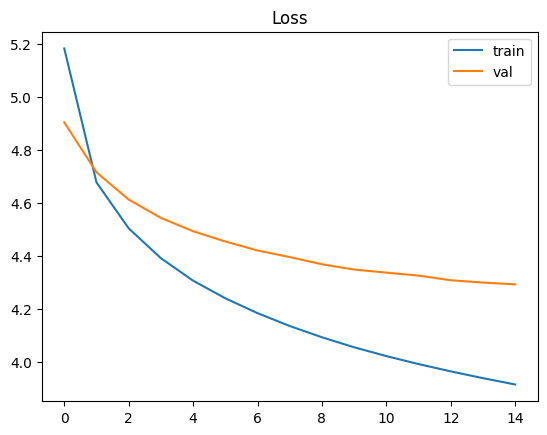

In [67]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend(); plt.title("Loss"); plt.show()

### Saving best model

In [68]:
best = tf.keras.models.load_model("day75_lstm_textgen.keras")
import json
with open("day75_tokenizer.json","w",encoding="utf-8") as f:
    f.write(tokenizer.to_json())


In [69]:
def val_perplexity_subset(model, ds, batches=200):
    import numpy as np
    nll, n, seen = 0.0, 0, 0
    for xb, yb in ds:
        probs = model.predict(xb, verbose=0).astype(np.float64)
        y = yb.numpy().astype(np.int64)
        p = probs[np.arange(len(y)), y]
        p = np.clip(p, 1e-12, 1.0)
        nll += -np.log(p).sum()
        n += len(y); seen += 1
        if seen >= batches: break
    return float(np.exp(nll / max(1, n)))

print("Subset Perplexity:", round(val_perplexity_subset(best, ds_val, batches=200), 2))


Subset Perplexity: 54.43


In [72]:
ppl = val_perplexity(best, ds_val)  # full ds_val, not subset
print("Validation Perplexity:", round(ppl, 2))


Validation Perplexity: 73.18


In [ ]:
import numpy as np, re, tensorflow as tf

# ---------- helpers ----------
def _safe_normalize(p, eps=1e-12):
    p = np.asarray(p, dtype=np.float64)
    p[~np.isfinite(p)] = 0.0
    s = p.sum()
    if s <= eps:
        nz = np.flatnonzero(p)
        if len(nz) == 0:
            p[:] = 1.0 / len(p)
        else:
            p[:] = 0.0
            p[nz] = 1.0 / len(nz)
    else:
        p /= s
    return p

def sample_with_controls(probs, top_k=50, top_p=0.95, temperature=0.9):
    p = np.asarray(probs, dtype=np.float64)
    p = np.maximum(p, 1e-20)
    p = np.log(p) / max(1e-6, temperature)
    p = np.exp(p)
    p = _safe_normalize(p)

    if top_k and 0 < top_k < len(p):
        keep = np.argpartition(-p, top_k)[:top_k]
        mask = np.ones_like(p, bool); mask[keep] = False
        p[mask] = 0.0; p = _safe_normalize(p)

    if top_p and 0 < top_p < 1:
        order = np.argsort(-p); cum = np.cumsum(p[order])
        cut = order[cum > top_p]
        p[cut] = 0.0; p = _safe_normalize(p)
    return np.random.choice(len(p), p=p)

# ---------- id maps / categories ----------
word_to_id = tokenizer.word_index
id_to_word = {idx: w for w, idx in word_to_id.items()}
pad_idx = 0
oov_idx = word_to_id.get("<oov>")
eos_idx = word_to_id.get("<eos>")

_PUNCTS = {".", ",", ";", ":", "!", "?", "-", "(", ")", '"', "…"}
PUNCT_IDS = {word_to_id[p] for p in _PUNCTS if p in word_to_id}

FUNC_WORDS = {"and","of","in","to","with","by","on","as","at","from","into","under","for","up","over"}
FUNC_IDS = {word_to_id[w] for w in FUNC_WORDS if w in word_to_id}

_ALNUM_RE = re.compile(r"[a-z0-9]+")

def _too_many_funcs(recent_words, limit=3):
    c = 0
    for w in reversed(recent_words):
        if w in FUNC_WORDS: c += 1
        else: break
    return c >= limit

def _postprocess(text):
    text = text.replace(" <eos>", ".")
    text = re.sub(r"\s+([,;:.!?])", r"\1", text)
    text = re.sub(r"([(\"])\s+", r"\1", text)
    text = re.sub(r"\s+([\")])", r"\1", text)
    text = re.sub(r"([,;:.!?-])\s*\1+", r"\1", text)  # collapse repeated punct
    text = re.sub(r"\s+", " ", text).strip()
    return text

# ---------- generator ----------
def generate(seed_text,
             max_new_tokens=120,
             temperature=0.85,
             top_k=50,
             top_p=0.90,
             repeat_penalty=1.07,
             min_words_between_punct=2,
             min_words_between_eos=8,
             ban_oov=True):
    out = seed_text.strip().lower()
    recent_ids = []
    words_since_punct = 999
    words_since_eos = 999

    for _ in range(max_new_tokens):
        ids = tokenizer.texts_to_sequences([out])[0]
        seq = tf.keras.preprocessing.sequence.pad_sequences(
            [ids], maxlen=WIN, padding='post', truncating='pre'
        )
        probs = best.predict(seq, verbose=0)[0].astype(np.float64)

        # hard bans
        if pad_idx < len(probs): probs[pad_idx] = 0.0
        if ban_oov and oov_idx is not None and oov_idx < len(probs):
            probs[oov_idx] = 0.0

        # discourage <eos> if sentence too short
        if eos_idx is not None and eos_idx < len(probs) and words_since_eos < min_words_between_eos:
            probs[eos_idx] *= 0.3

        # light repetition penalty
        for w in recent_ids[-20:]:
            if 0 <= w < len(probs):
                probs[w] /= repeat_penalty

        # punctuation controls
        last_is_punct = (recent_ids and recent_ids[-1] in PUNCT_IDS)
        if last_is_punct or words_since_punct < min_words_between_punct:
            for pid in PUNCT_IDS:
                if pid < len(probs): probs[pid] *= 0.2

        # function-word cooldown
        last_words = [id_to_word.get(i, "") for i in recent_ids[-6:]]
        if _too_many_funcs(last_words, limit=3):
            for fid in FUNC_IDS:
                if fid < len(probs): probs[fid] *= 0.25

        probs = _safe_normalize(probs)

        # resample until a valid token is chosen (bounded tries)
        for _try in range(12):
            idx = sample_with_controls(probs, top_k=top_k, top_p=top_p, temperature=temperature)
            if (idx in PUNCT_IDS and words_since_punct < min_words_between_punct) \
               or (idx == eos_idx and words_since_eos < min_words_between_eos):
                probs[idx] = 0.0; probs = _safe_normalize(probs)
                continue
            break
        else:
            # as a last resort, take argmax of remaining mass
            idx = int(np.argmax(probs))

        w = id_to_word.get(int(idx), "")
        if not w:
            # if unmapped (shouldn't happen), skip
            continue

        # append token
        out += " " + w
        recent_ids.append(int(idx))

        if idx in PUNCT_IDS:
            words_since_punct = 0
        else:
            words_since_punct += 1

        if idx == eos_idx:
            words_since_eos = 0
        else:
            words_since_eos += 1

    return _postprocess(out)


In [84]:
# Build maps
word_to_id = tokenizer.word_index
id_to_word = {idx: w for w, idx in word_to_id.items()}

# Find all plausible OOV spellings and the configured one
oov_variants = {"<OOV>", "<oov>", "<unk>", "<UNK>"}
if getattr(tokenizer, "oov_token", None):
    oov_variants.add(tokenizer.oov_token)

OOV_IDS = {word_to_id[w] for w in oov_variants if w in word_to_id}

# (Optional) sanity check
print("Tokenizer oov_token:", getattr(tokenizer, "oov_token", None))
print("Resolved OOV tokens:", sorted(list(oov_variants & set(word_to_id.keys()))))
print("Resolved OOV ids   :", sorted(list(OOV_IDS)))


Tokenizer oov_token: <OOV>
Resolved OOV tokens: ['<OOV>']
Resolved OOV ids   : [1]


In [82]:
print(generate(
    "once upon a time",
    140,
    temperature=0.8,
    top_k=45,
    top_p=0.9,
    repeat_penalty=1.08,
    min_words_between_punct=3
))


once upon a time. on <OOV> in and to and at. on in and. around and in. <OOV> <OOV> in on and from on on on - to in <OOV> as in - which which in. as in from from that, in to to into, <OOV> <OOV> in, the the of of the country - <OOV> <OOV> is a <OOV> <OOV>. walks by all the <OOV> of his crew, <OOV> to the pequod's <OOV>, he must be able report to <OOV>. cave in <OOV>, <OOV> that the <OOV> of the sperm whale fishery, the pequod was in a large <OOV>. recognised the ship, and all this <OOV> of <OOV> <OOV> <OOV>; while the ship was inserted in, the ship was a great <OOV> - boat <OOV>


In [88]:
import numpy as np, tensorflow as tf

# 0) Make sure the model is built
_ = best.predict(np.zeros((1, WIN), dtype=np.int32), verbose=0)

# 1) Create a fp32 softmax head (no retraining)
base = tf.keras.Model(inputs=best.input, outputs=best.layers[-2].output)
fp32_head = tf.keras.layers.Dense(vocab_size, activation="softmax",
                                  dtype="float32", name="fp32_head")

best_fp32 = tf.keras.Model(base.input, fp32_head(base.output))

# Alternate: force-build without running predict
best.build((None, WIN))
_ = best(tf.zeros((1, WIN), dtype=tf.int32), training=False)  # one call to finalize graph


# 2) Copy weights from the old head -> new head (cast to float32)
old_w = best.layers[-1].get_weights()
fp32_head.set_weights([w.astype("float32") for w in old_w])

# 3) Sanity check: forward should now be finite
xb, _ = next(iter(ds_train))
preds = best_fp32(xb[:1], training=False).numpy()
import numpy as np
print("Pred finite:", np.isfinite(preds).all())


AttributeError: The layer sequential_4 has never been called and thus has no defined input.

In [ ]:
print(generate("once upon a time", 120))
print(generate("in a small village by the sea", 150, temperature=0.8, top_k=60, top_p=0.9))



once upon a time - with and. on up in which, and in and. out for, which as. with a under. under to by which - for on. with to in. and at, of and. in and, over as. as of at <OOV>, upon his, voice of the <OOV> was a strange way, of course the <OOV> of the most <OOV> of the <OOV>; and so the <OOV>, <OOV> of all <OOV>, <OOV> all the <OOV> of <OOV>. jaw to <OOV> it, was as <OOV> as it had a <OOV>. uncle's <OOV> the whole <OOV> of the <OOV> <OOV>, so that it
in a small village by the sea. on upon. under and about in in. as on and and at. with a. the on a in, in as and in and and. and and and and. on the. and in. into to, the by away to in and he a great <OOV> and the <OOV>. hast was about the <OOV> of the <OOV>, as if he were about to <OOV> the earth with him and the <OOV> <OOV>. raging <OOV>, that of the other hand, he would find himself a great deal to tell him how it was, and he had been <OOV> and <OOV> in the course reproach, and he <OOV>. walking his heart and he could not get into a ce

In [80]:
print(generate("once upon a time", 60, temperature=0.8, top_k=45, top_p=0.9))


once upon a time; with in. and and <OOV> on and. with up and. to in under. <OOV> at. up a on, which to. under in on. under on. and and. a as into in. into to; of on. and to, into to, it was a very curious


In [76]:
print(generate("once upon a time", 150))
print(generate("in a small village by the sea", 150, temperature=0.85, top_k=60, top_p=0.92))

once upon a time. and like <OOV>. <OOV> for... on, on and,,,. on at. upon in. to. from and into, by with which for and. and for, for.,...,.. on to, <OOV> to,, <OOV>, <OOV>. shrine. lasted, when you were going into the place, there was no, we <OOV>, but the <OOV> of the two - heads, and it was a pleasant one. logs, we have not seen, i should have taken a <OOV>, and then i am to be <OOV> the way, and i will stay there in time for us. minerva, " " what is you going, and i can, " said the <OOV>. a', " that
in a small village by the sea. upon -. <OOV>...., in through.. and in... in for on in in from through and through with through down on. and, the. from...,. <OOV> of.., with. <OOV> the, <OOV> <OOV> voice in which a moment, and the <OOV> of a <OOV>, a low, thin - <OOV> of a kind - tree <OOV>; with the <OOV> - and - <OOV> <OOV>, which was like an most <OOV> manner, which was much larger powerful goal than ever. organ, not the white whale of a hundred - four - <OOV> <OOV>, were <OOV>, that <